In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

from E27_Medical_Image_Data_Preprocessing import *
import UNet
import VGG16
import model_test

2.3.1


In [2]:
batch_size = 8
max_epochs = 50

DATASET_PATH = os.path.join(os.getenv("HOME"),'aiffel/medical')
img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

In [3]:
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames, num_train_examples, num_test_examples = \
    get_train_test_files(img_dir, label_dir)

# of training examples : 480
# of test examples : 120


In [4]:
train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames, batch_size=batch_size)
train_dataset = train_dataset.repeat()

it works


In [5]:
test_dataset = get_baseline_dataset(x_test_filenames, y_test_filenames, batch_size=batch_size, is_train=False)

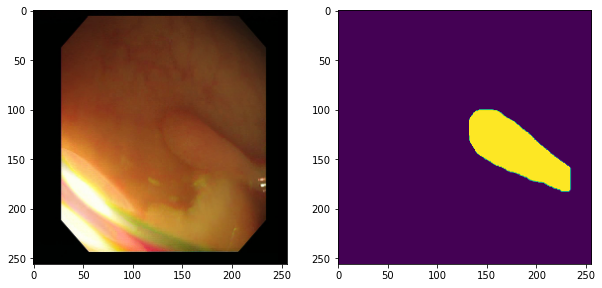

In [6]:
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    img = images[0]
     
    plt.subplot(1,2,1)
    plt.imshow(img)
     
    plt.subplot(1,2,2)
    plt.imshow(labels[0,:,:,0])
    plt.show()

### Loss function

In [7]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f*y_pred_f)
    score = (2.*intersection+smooth)/(tf.reduce_sum(tf.square(y_true_f))+\
                                     tf.reduce_sum(tf.square(y_pred_f))+smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true,y_pred)) +\
                         dice_loss(y_true,y_pred)
    return loss

In [8]:
optimizer = tf.keras.optimizers.Adam()

### Model Training
#### 1) U-Net

In [9]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
unet_model = UNet.UNet()

In [11]:
model = unet_model
checkpoint_dir = os.path.join(DATASET_PATH,'train_ckpt/unet_model')

In [12]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions= model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


In [13]:
model.summary()

Model: "u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block (EncoderBlock) multiple                  76416     
_________________________________________________________________
encoder_block_1 (EncoderBloc multiple                  444288    
_________________________________________________________________
encoder_block_2 (EncoderBloc multiple                  1773312   
_________________________________________________________________
encoder_block_3 (EncoderBloc multiple                  7085568   
_________________________________________________________________
conv_block_4 (ConvBlock)     multiple                  28326912  
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  18882048  
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  354278

In [26]:
vgg_model = VGG16.Vgg16UNet()

In [27]:
model = vgg_model
checkpoint_dir = os.path.join(DATASET_PATH,'train_ckpt/vgg_model')

In [28]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions= model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(8, 256, 256, 1)


### Callbacks

In [29]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

cos_decay = tf.keras.experimental.CosineDecay(1e-3, max_epochs)
lr_callbacks = tf.keras.callbacks.LearningRateScheduler(cos_decay,verbose=1)

In [30]:
def print_images(test_dataset):
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)
        
        plt.figure(figsize=(10,20))
        plt.subplot(1,3,1)
        plt.imshow(test_image[0,:,:,:])
        plt.title("Input image")
        
        plt.subplot(1,3,2)
        plt.imshow(test_labels[0,:,:,0])
        plt.title("Actual Mask")
        
        plt.subplot(1,3,3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [31]:
test_dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [20]:
history_unet = model.fit(train_dataset,
                        epochs=max_epochs,
                        steps_per_epoch=num_train_examples//batch_size,
                        validation_data=test_dataset,
                        validation_steps=num_test_examples//batch_size,
                        callbacks=[cp_callbacks, lr_callbacks])


Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/50
60/60 [==============================] - 24s 405ms/step - loss: 0.8889 - dice_loss: 0.6209 - val_loss: 1.2927 - val_dice_loss: 0.8610

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990134, shape=(), dtype=float32).
Epoch 2/50
60/60 [==============================] - 26s 426ms/step - loss: 0.6399 - dice_loss: 0.4770 - val_loss: 1.0020 - val_dice_loss: 0.8039

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009960574, shape=(), dtype=float32).
Epoch 3/50
60/60 [==============================] - 24s 392ms/step - loss: 0.5655 - dice_loss: 0.4259 - val_loss: 1.0777 - val_dice_loss: 0.6718

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009911436, shape=(), dtype=float32).
Epoch 4/50
60/60 [==============================] - 23s 390ms/step - loss: 0.4773 - dice_loss: 0.3589 - val_loss: 2.5740 - v

In [17]:
new_model = UNet.UNet()

In [18]:
new_model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

In [20]:
checkpoint_dir

'/home/aiffel0042/aiffel/medical/train_ckpt/unet_model'

In [21]:
new_model.load_weights(checkpoint_dir)

In [39]:
new_model = VGG16.Vgg16UNet()

In [40]:
new_model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])

In [41]:
checkpoint_dir

'/home/aiffel0042/aiffel/medical/train_ckpt/vgg_model'

In [42]:
new_model.load_weights(checkpoint_dir)

In [43]:
## Define print function
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = new_model(test_images, training=False)

        for i in range(3):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

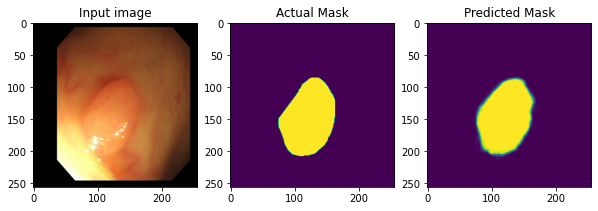

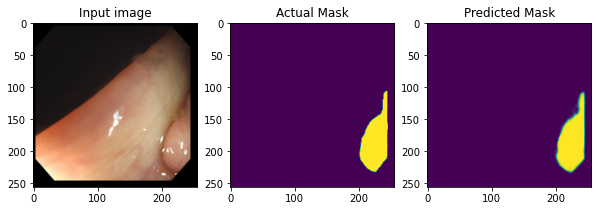

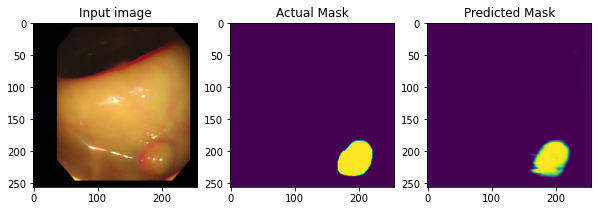

In [44]:
print_images()

In [38]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = model_test.mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.031827930033132695


### 정리
  
UNet을 이용하여 데이터 segmentation을 이용하여 용종 검출 모델을 학습해보았다.  
이후 VGG모델을 백본으로 하여 사전학습된 모델을 인코더로 사용하여 두 모델의 성능을 비교하였다.  